In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Задание 1

В задаче будет рассмотрен метод кластеризации `K-means` для решения непосредственно задачи кластеризации — задачи выделения схожих структур в данных. Работать будем с известным набором данных <a href="http://yann.lecun.com/exdb/mnist/">`MNIST`</a>.

Загрузим набор данных. Будем использовать только тестовую часть оригинального набора, чтобы сократить время обучения моделей.

In [2]:
from keras.datasets import mnist
import warnings
warnings.filterwarnings("ignore")

(_,_), (X, y) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


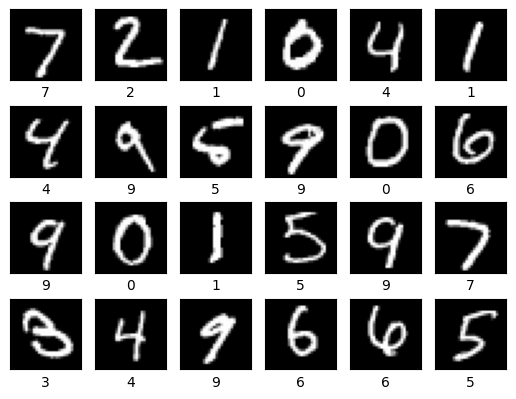

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(y[i],
                   color='black')

При помощи `train_test_split` разобьем полученный набор данных на тренеровочную и тестовую выборки.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

Заставим `K-means` искать $10$ групп объектов.

«Распрямим» изображения и обучим алгоритм `KMeans`.

In [5]:
def flatten_images(images):
    return images.reshape((images.shape[0], -1))

X_flat = flatten_images(X_train)

k_means = KMeans(random_state=35, n_clusters=10)
k_means.fit(X_flat, y_train)

KMeans(n_clusters=10, random_state=35)

Определим число элементов, отнесенных к кластерам с разными метками.

In [6]:
pd.DataFrame(k_means.labels_).value_counts()

,count
0,
4,1097
6,984
2,892
3,878
1,806
9,744
7,710
5,700
0,620


Построим изображения, соответствующие центроидам полученных кластеров.



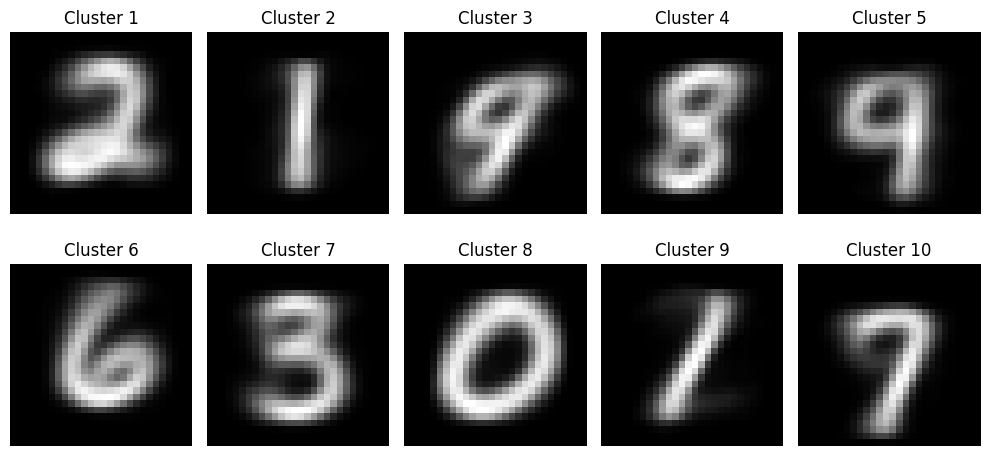

In [7]:
centroids = k_means.cluster_centers_

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i, centroid in enumerate(centroids):

    centroid_image = centroid.reshape(28, 28)

    axes[i].imshow(centroid_image, cmap='gray')
    axes[i].set_title(f'Cluster {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Можно заметить, что получившиеся картинки весьма походят на рукописные цифры. Впрочем, кластеризация прошла не без накладок.

Так как получившиеся кластеры ничего не знают о природе кластеризумых объектов, метки кластеров могут отличаться от «разумных меток». Восстановим правильные метки, используя следующие соображения: кластеру присваивается метка тех цифр, представителей которых в кластере большинство.

Выведем полученные метки кластеров после преобразования.

In [8]:
df_fair = pd.concat([pd.DataFrame(k_means.labels_, columns=['k_means_label']),
                     pd.DataFrame(y_train, columns=['true_label'])], axis=1)
vals = df_fair.groupby('k_means_label').agg(pd.Series.mode).values
for val in vals:
  print(*val, end=',')

2,1,4,8,4,6,3,0,1,7,

Разумно оценить что-то вроде точности. Считая, что все объекты кластера имеют ту же метку, что и сам кластер, сравним эти метки с истинными метками. Вычислим `accuracy`.

In [ ]:
k_means.labels_

array([6, 4, 0, ..., 1, 1, 6], dtype=int32)

In [ ]:
accuracy_score([vals[i] for i in k_means.labels_], y_train)

0.625875

Произведем кластеризацию тестовых данных. Переименуем метки предсказанных кластеров на основе полученного для тренировочного набора данных преобразования.

In [ ]:
X_flat_test = flatten_images(X_test)
y_pred = k_means.predict(X_flat_test)
accuracy_score([vals[i] for i in y_pred], y_test)

0.6325

Построим матрицу ошибок.

In [ ]:
cm = confusion_matrix(y_test, [vals[i] for i in y_pred])

Text(0.5, 23.52222222222222, 'Predicted label')

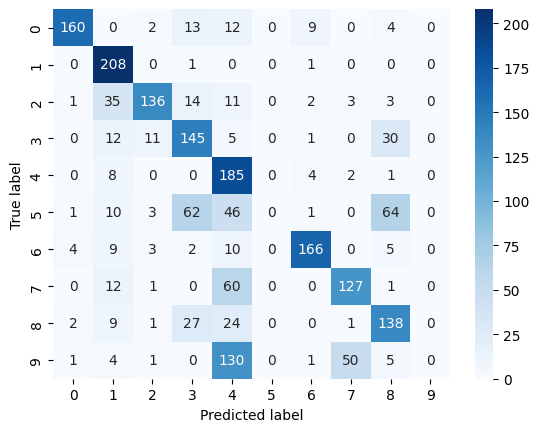

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Построенная модель чаще всего путала цифру 9 с цифрой 4.

Все эти обучения черезчур уж долгие. Понизим размерность данных, пытаясь сохранять расстояния между объектами. Посмотрим, как это скажется на скорости и точности.

Преобразуем тренировочный набор данных при помощи метода <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html"><code>TSNE</code></a>.

In [ ]:
tsne = TSNE(n_components=2, init='random', random_state=35)
train_tsne = tsne.fit_transform(X_flat)

Произведем кластеризацию полученного набора данных при помощи `KMeans`. Аналогично проделанному раньше переназначем метки кластеров на основе метки большинства объектов в рамках кластера. Оценим точность модели на тренировочных данных.

In [ ]:
k_means_tsne = KMeans(random_state=35, n_clusters=10)
k_means_tsne.fit(train_tsne)

KMeans(n_clusters=10, random_state=35)

In [ ]:
df_fair = pd.concat([pd.DataFrame(k_means_tsne.labels_, columns=['k_means_label']),
                     pd.DataFrame(y_train, columns=['true_label'])], axis=1)
vals = df_fair.groupby('k_means_label').agg(pd.Series.mode).values
accuracy_score([vals[i] for i in k_means_tsne.labels_], y_train)

0.770125

#Задание 2

Кластеризация может применяться для сжатия изображений. Поработаем со следующим изображением.

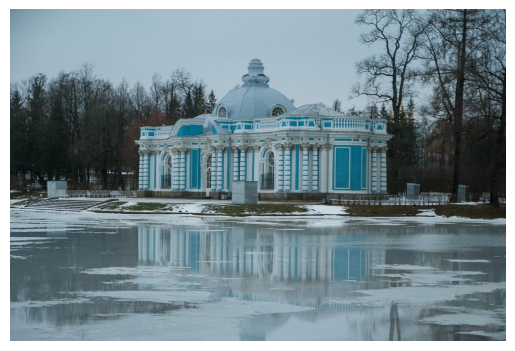

In [ ]:
img_path = '/content/spb_barocco.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

Перед нами трехканальное (RGB) изображение. Вычислим среднее значение интенсивности пикселей по всем каналам.

In [ ]:
intensity = np.mean(img, axis=(0, 1))
intensity.mean()

121.34244974201714

Нормируем значения интенсивностей пикселей, разделив все значения на $255$. Вычислим среднее значение интенсивности пикселей по всем каналам после проделанного преобразования.

In [ ]:
img_norm = img / 255.0
np.mean(img_norm, axis=(0, 1)).mean()

0.4758527440849316

Убедимся в том, что исходное пространство цветов, насчитывающее около $16$ миллионов возможных состояний ($256^3$), слишком велико, и его размерность можно понижать. Для наглядности построим лишь некоторые подвыборки зависимостей значений интенсивностей и лишь на случайном поднаборе пикселей.

«Распрямим» изображение так, чтобы `.shape` соответствущего массива имел вид `(высота * ширина, 3)`/

In [ ]:
def plot_pixels(data, colors=None, N=10000):
    if colors is None:
        colors = data

    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

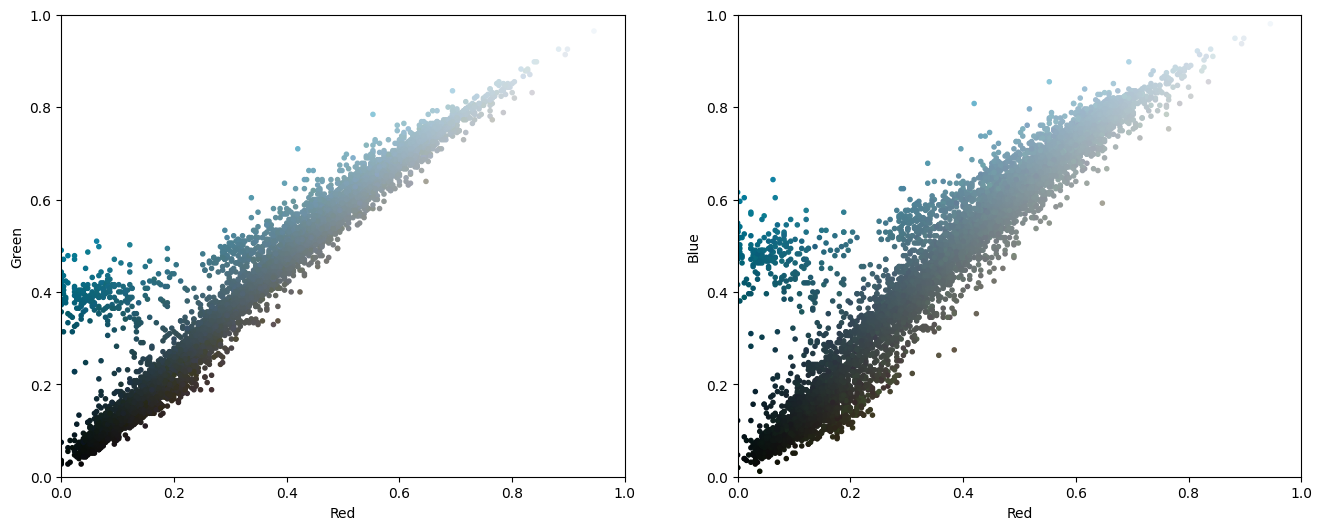

In [ ]:
img_flat = img_norm.reshape(-1, 3)

plot_pixels(img_flat)
plt.show()

Переведем 16 миллионов возможностей во всего-навсего 16 возможностей, используя `K-means`. Правда, чтобы ускорить работу алгоритма, будем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html"><code>K-means</code> на батчах</a> — поднаборах данных. Заодно увидим, портит ли это результат.

Обучим модель <code>MiniBatchKMeans</code> на нормированном и «распрямленном» изображении.

В изображении заменим значения цветов каждого пикселя на значения координат центроида кластера к которому был отнесен этот пиксель. Построим графики зависимостей цветов при помощи <code>plot_pixels()</code> с новой палитрой.


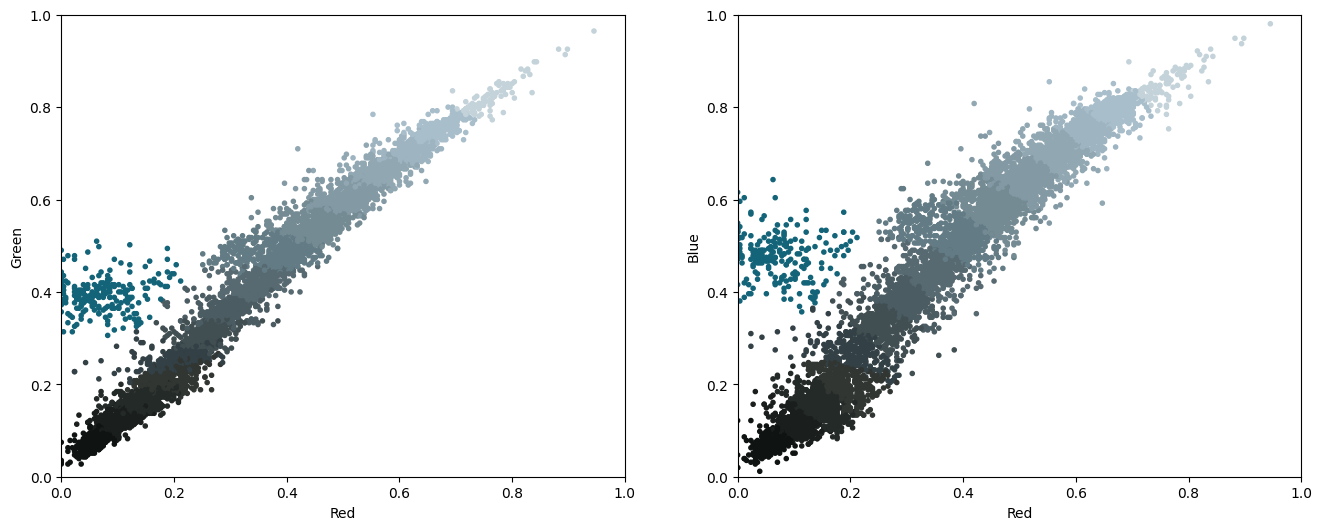

In [ ]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=16, random_state=12)
kmeans.fit(img_flat)
new_colors = kmeans.cluster_centers_[kmeans.predict(img_flat)]
plot_pixels(img_flat, colors=new_colors)
plt.show()

Вычислим среднее значение интенсивности пикселей полученного изображения.

In [ ]:
np.mean(new_colors, axis=0).mean()

0.4759660443462877

Пора смотреть на результат! Построим изображение, в котором используется лишь $16$ цветов.

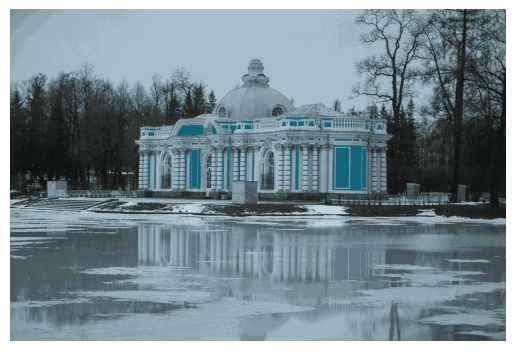

In [ ]:
new_img = kmeans.cluster_centers_[kmeans.predict(img_flat)]
plt.axis('off')
plt.imshow(new_img.reshape(img.shape))
plt.show()

Построим изображение размера $4 \times 4$ на основе полученных $16$ цветов.

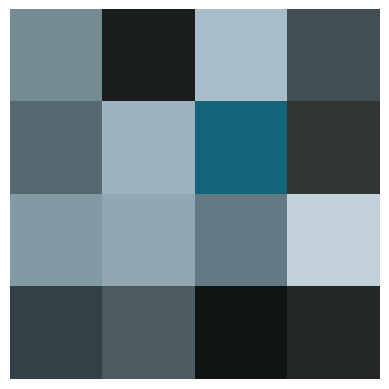

In [ ]:
img_sm = kmeans.cluster_centers_.reshape((4, 4, 3))

plt.axis('off')
plt.imshow(img_sm)
plt.show()

#Задание 3

Рассмотрим пример созадния генеративной модели на основе гауссовых смесей. Работать будем опять-таки с `MNIST`. Так как модель оказывается крайне тяжеловесной, будем использовать «простой» набор данных. Визуализируем элементы этого набора данных (для наглядности)

In [ ]:
digits = load_digits()
digits.data.shape

(1797, 64)

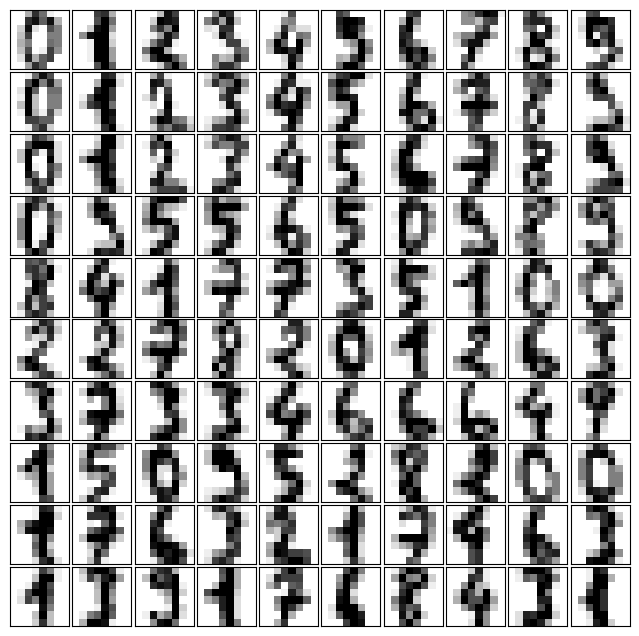

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for i, axi in enumerate(ax.flat):
    im = axi.imshow(digits.data[i].reshape(8,8), cmap='binary')
    im.set_clim(0, 16)

Для того, чтобы обучение проходило быстрее имеет смысл снизить размерность пространства признаков. Произведем преобразования для всего набора данных помощи `PCA`.


In [ ]:
pca = PCA(n_components=0.99, svd_solver='full')
df = pca.fit_transform(digits.data)
df.shape[1]

41

Получилась 41 главная компонента.

Обучим интересующую нас модель, подобрав гиперпараметр, отвечающий за число используемых компонент, минимизируя <a href="https://ru.wikipedia.org/wiki/Информационный_критерий_Акаике">информационный критерий Акаике</a>.

Для значений параметра <code>n_components</code> в диапазоне $[50,250)$ с шагом $10$ обучим модели <a href="https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html"><code>GaussianMixture</code></a>. При помоши метода <code>.aic()</code> вычислим значение критерия каждой модели.

Выведем значение <code>n_components</code> модели с наименьшим значением критерия Акаике.

In [ ]:
n = 50
gm = GaussianMixture(n_components=n, covariance_type='full', random_state=11)
gm.fit(df)
aic = gm.aic(df)

res = []
for n_components in range(60, 250, 10):
  gm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=11)
  gm.fit(df)
  if gm.aic(df) < aic:
    aic = gm.aic(df)
    n = n_components
n

180

Обучим финальную модель на подобранном гиперпараметре. Проверим, что обучение сошлось.

In [ ]:
gm = GaussianMixture(n_components=180, covariance_type='full', random_state=11)
gm.fit(df)
gm.converged_

True

При помощи метода <code>.sample()</code> сгенерируем $100$ новых объектов.

Выведем выборочное среднее коориднаты с индексом $0$ сгенерированных объектов.

In [ ]:
sample = gm.sample(100)
sample[0][:,0].mean()

-1.7925848845557741

Вернем сгенерированные объекты в пространство исходных признаков.

In [ ]:
inverse_sample = pca.inverse_transform(sample[0])

Визуализируем полученные результаты.

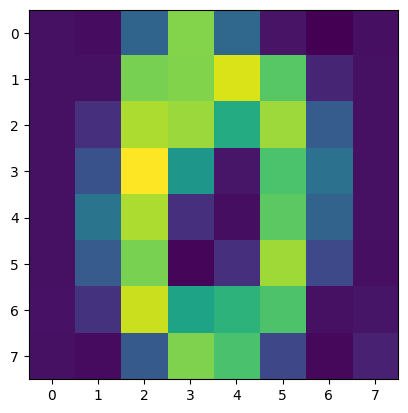

In [ ]:
plt.imshow(inverse_sample[17].reshape(8,8))